# 深度學習影像分類專案說明

本專案使用 PyTorch 框架實作深度學習影像分類模型。主要功能包括:

1. 使用預訓練模型進行遷移學習
2. 資料集包含50個類別的影像
3. 實作資料增強(Data Augmentation)提升模型泛化能力
4. 使用 GPU 加速訓練過程
5. 包含訓練過程視覺化與混淆矩陣分析


# 1. Import 必要套件

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 2. 檢查訓練設備

In [42]:
# 檢查 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# 3. 設定訓練參數

In [43]:
# 設定參數
DATA_DIR = "/home/ouvic/ML/ComputerVision_HW3/all_data"  # 替換為您的資料夾路徑
BATCH_SIZE = 32
NUM_CLASSES = 50
EPOCHS = 30
LEARNING_RATE = 1e-4
IMG_SIZE = (224, 224)  # 圖片大小

# 4. 資料處理與增強
使用 torchvision.transforms 進行資料預處理與增強
- Resize: 將圖片調整為統一大小 224x224
- RandomHorizontalFlip: 隨機水平翻轉增加資料多樣性
- RandomRotation: 隨機旋轉增加資料多樣性 
- ToTensor: 將圖片轉換為 Tensor 格式
- Normalize: 使用 ImageNet 預訓練模型的標準化參數

In [44]:
# 資料增強與轉換
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# 加載資料
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training data: {len(train_dataset)} images, Test data: {len(test_dataset)} images")

Training data: 84282 images, Test data: 21096 images


# 5. 定義預訓練模型(Transfer Learning )

In [45]:
# 加載預訓練模型
model_name = "resnet152"  # 可以是 "alexnet", "densenet201", "vgg19", "resnet152" 等

if model_name == "alexnet":
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
elif model_name == "vgg19":
    model = models.vgg19(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
elif model_name == "densenet201":
    model = models.densenet201(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
elif model_name == "resnet152":
    model = models.resnet152(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
elif model_name == "efficientnet":
    model = models.efficientnet_b5(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    
elif model_name == "resnext101":
    model = models.resnext101_64x4d(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
else:
    raise ValueError("Unsupported model name")

# 將模型移至 GPU
model = model.to(DEVICE)
# print(model)
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 6. 定義Loss Function 跟 Optimizer

In [46]:
# 定義 Focal Loss
# 資料不平衡問題，使用 Focal Loss 來解決
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

# 定義損失函數和優化器
criterion = FocalLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 7. 建立訓練方法

In [47]:
# 訓練函數
def train_model(model, dataloader, criterion, optimizer, device, num_classes):
    model.train()
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    # 初始化 Precision 和 Recall 的計數器
    true_positive = torch.zeros(num_classes).to(device)
    false_positive = torch.zeros(num_classes).to(device)
    false_negative = torch.zeros(num_classes).to(device)
    
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # _, predicted = outputs.max(1)
        _, predicted = outputs.topk(5, 1, True, True)  # 取得 Top-5 的預測
        total += labels.size(0)
        # correct += predicted.eq(labels).sum().item()
        # 計算 Top-1 和 Top-5 Accuracy
        correct_top1 += (predicted[:, 0] == labels).sum().item()
        correct_top5 += sum([labels[i].item() in predicted[i] for i in range(labels.size(0))])
        
        # 更新 Precision 和 Recall 的計數
        for i in range(labels.size(0)):  # 遍歷每個樣本
            label = labels[i].item()  # 真實標籤
            if predicted[i, 0] == label:  # Top-1 正確
                true_positive[label] += 1
            else:
                false_positive[predicted[i, 0]] += 1  # Top-1 錯誤增加 FP
                false_negative[label] += 1  # 錯誤的真實標籤增加 FN
        
    epoch_loss = running_loss / len(dataloader)
    epoch_top1_acc = correct_top1 / total
    epoch_top5_acc = correct_top5 / total
    
    # 計算 Precision 和 Recall
    precision = true_positive / (true_positive + false_positive + 1e-8)
    recall = true_positive / (true_positive + false_negative + 1e-8)
    
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, precision.mean().item(), recall.mean().item()

# 7. 建立驗證方法

In [48]:
# 驗證函數
def validate_model(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    
    # 初始化 Precision 和 Recall 的計數器
    true_positive = torch.zeros(num_classes).to(device)
    false_positive = torch.zeros(num_classes).to(device)
    false_negative = torch.zeros(num_classes).to(device)
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # _, predicted = outputs.max(1)
            # correct += predicted.eq(labels).sum().item()
            _, predicted = outputs.topk(5, 1, True, True)  # 取得 Top-5 的預測
            total += labels.size(0)
            
            # 計算 Top-1 和 Top-5 Accuracy
            correct_top1 += (predicted[:, 0] == labels).sum().item()
            correct_top5 += sum([labels[i].item() in predicted[i] for i in range(labels.size(0))])
            
            # 更新 Precision 和 Recall 的計數
            for i in range(labels.size(0)):  # 遍歷每個樣本
                label = labels[i].item()  # 真實標籤
                if predicted[i, 0] == label:  # Top-1 正確
                    true_positive[label] += 1
                else:
                    false_positive[predicted[i, 0]] += 1  # Top-1 錯誤增加 FP
                    false_negative[label] += 1  # 錯誤的真實標籤增加 FN
            
    epoch_loss = running_loss / len(dataloader)
    epoch_top1_acc = correct_top1 / total
    epoch_top5_acc = correct_top5 / total
    
    # 計算 Precision 和 Recall
    precision = true_positive / (true_positive + false_positive + 1e-8)
    recall = true_positive / (true_positive + false_negative + 1e-8)
    
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, precision.mean().item(), recall.mean().item()

# 9. 開始訓練

In [ ]:
train_losses = []  # 訓練損失的數據
val_losses = []    # 驗證損失的數據
train_top1_accuracies = []  # 訓練準確率的數據
train_top5_accuracies = []  # 訓練準確率的數據
val_top1_accuracies = []    # 驗證準確率的數據
val_top5_accuracies = []    # 驗證準確率的數據
train_precisions = []
train_recalls = []
val_precisions = []
val_recalls = []
# 開始訓練
for epoch in range(EPOCHS):
    train_loss, train_top1_acc, train_top5_acc, train_precision, train_recall = train_model(
        model, train_loader, criterion, optimizer, DEVICE, NUM_CLASSES
    )
    val_loss, val_top1_acc, val_top5_acc, val_precision, val_recall = validate_model(
        model, test_loader, criterion, DEVICE, NUM_CLASSES
    )
    
    # 收集訓練和驗證的損失與準確率
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_top1_accuracies.append(train_top1_acc) 
    train_top5_accuracies.append(train_top5_acc)
    val_top1_accuracies.append(val_top1_acc)
    val_top5_accuracies.append(val_top5_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Top-1 Accuracy: {train_top1_acc:.4f}, Top-5 Accuracy: {train_top5_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Top-1 Accuracy: {val_top1_acc:.4f}, Top-5 Accuracy: {val_top5_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

# 儲存模型
torch.save(model.state_dict(), f"{model_name}_model_{EPOCHS}.pth")
print("Model saved!")

# 10. 計算驗證結果和混淆矩陣

In [37]:
# 假設 num_classes 是類別數量，val_loader 是驗證集 DataLoader
def plot_confusion_matrix(model, dataloader, device, class_names):
    """
    使用驗證數據集生成混淆矩陣並可視化
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    # 在驗證數據上推論
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 計算混淆矩陣
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    print(cm)
    # 可視化混淆矩陣
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{model_name} Confusion Matrix")
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

In [ ]:

# 使用該函數在最後一輪訓練後繪製混淆矩陣
class_names = [f"{i}" for i in range(NUM_CLASSES)]  # 替換為真實的類別名稱
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

# 11. 繪製訓練過程中的各項指標變化圖
 包含:
- Top-1 準確率
- Top-5 準確率  
- 精確度(Precision)
- 召回率(Recall)
- 損失值(Loss)


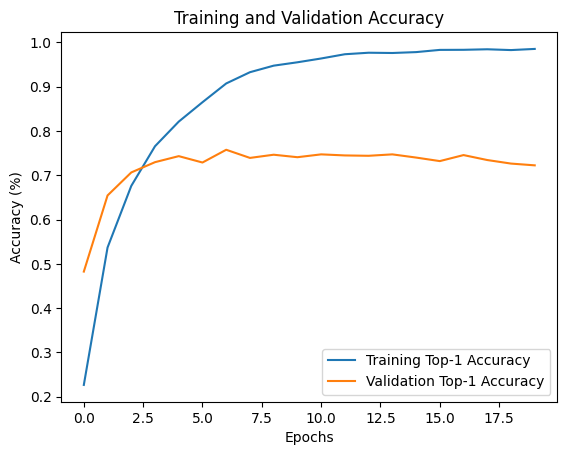

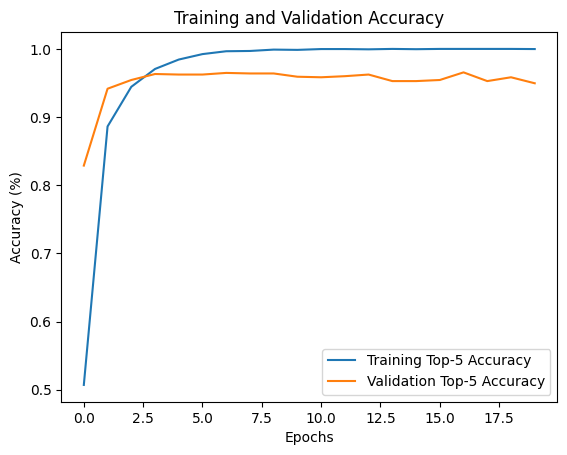

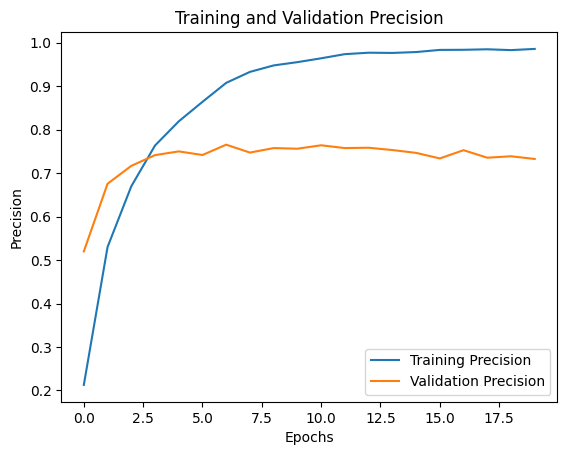

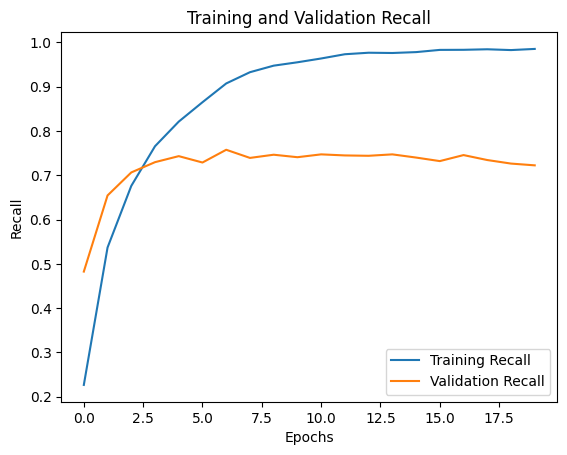

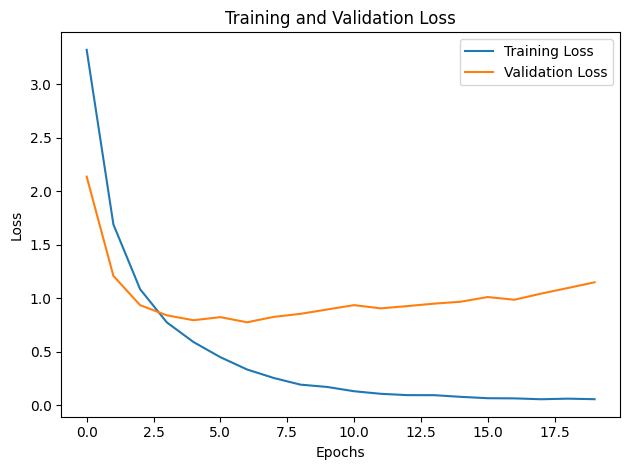

In [25]:
import matplotlib.pyplot as plt
epochs = len(train_losses)

plt.plot(train_top1_accuracies, label='Training Top-1 Accuracy')
plt.plot(val_top1_accuracies, label='Validation Top-1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
# plt.grid(True)
plt.savefig(f'{model_name}_accuracy_top1.png')
plt.show()


plt.plot(train_top5_accuracies, label='Training Top-5 Accuracy')
plt.plot(val_top5_accuracies, label='Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
# plt.grid(True)
plt.savefig(f'{model_name}_accuracy_top5.png')
plt.show()

plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
# plt.grid(True)
plt.savefig(f'{model_name}_precision.png')
plt.show()

plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
# plt.grid(True)
plt.savefig(f'{model_name}_recall.png')
plt.show()


plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.grid(True)
plt.savefig(f'{model_name}_loss.png')

plt.tight_layout()
plt.show()



# Inference

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os
from matplotlib import font_manager

In [28]:
# 設定參數
MODEL_PATH = "resnet152_model_30_1124.pth"  # 替換為訓練好的模型檔案路徑
DATA_DIR = "/home/ouvic/ML/ComputerVision_HW3/test_data/test2"  # 替換為要推論的圖片資料夾
NUM_CLASSES = 50  # 替換為分類的類別數量
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# 類別名稱（可從訓練數據的資料夾名稱生成）
# CLASS_NAMES = [f"class_{i}" for i in range(NUM_CLASSES)]  # 替換為真實的類別名稱
# CLASS_NAMES = train_dataset.classes
CLASS_NAMES = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']
print(CLASS_NAMES)
# # 從 printfolder.py 取得類別名稱
# CLASS_NAMES = [
#     "三杯雞", "什錦炒麵", "咖哩雞", "塔香海茸", "大陸妹",
#     "客家小炒", "小番茄", "有機小松菜", "有機青松菜", "木瓜",
#     "柳丁", "棗子", "橘子", "沙茶肉片", "油菜",
#     "洋蔥炒蛋", "滷蛋", "滷雞腿", "玉米炒蛋", "瓜仔肉",
#     "番茄炒蛋", "白米飯", "白菜滷", "福山萵苣", "空心菜",
#     "糖醋雞丁", "紅蘿蔔炒蛋", "義大利麵", "芥藍菜", "菠菜",
#     "葡萄", "蒜泥白肉", "蒸蛋", "蓮霧", "螞蟻上樹",
#     "西瓜", "豆芽菜", "關東煮", "青江菜", "香蕉",
#     "香酥魚排", "馬鈴薯燉肉", "高麗菜", "鳳梨", "鵝白菜",
#     "鹽酥雞", "麥克雞塊", "麻婆豆腐", "麻油雞", "黑胡椒豬柳"
# ]


# 資料增強與轉換
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [25]:
model_name = "resnet152"  # 可以是 "alexnet", "densenet201", "vgg19", "resnet152" 等

if model_name == "alexnet":
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
elif model_name == "vgg19":
    model = models.vgg19(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
elif model_name == "densenet201":
    model = models.densenet201(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
elif model_name == "resnet152":
    model = models.resnet152(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
elif model_name == "efficientnet":
    model = models.efficientnet_b5(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
elif model_name == "resnext101":
    model = models.resnext101_64x4d(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
else:
    raise ValueError("Unsupported model name")


model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

/tmp/ipykernel_424051/973809016.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
# 推論函數
def predict_image(image_path, model, transform, class_names, device):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # 增加 batch 維度
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = outputs.max(1)
    return image, class_names[predicted.item()]

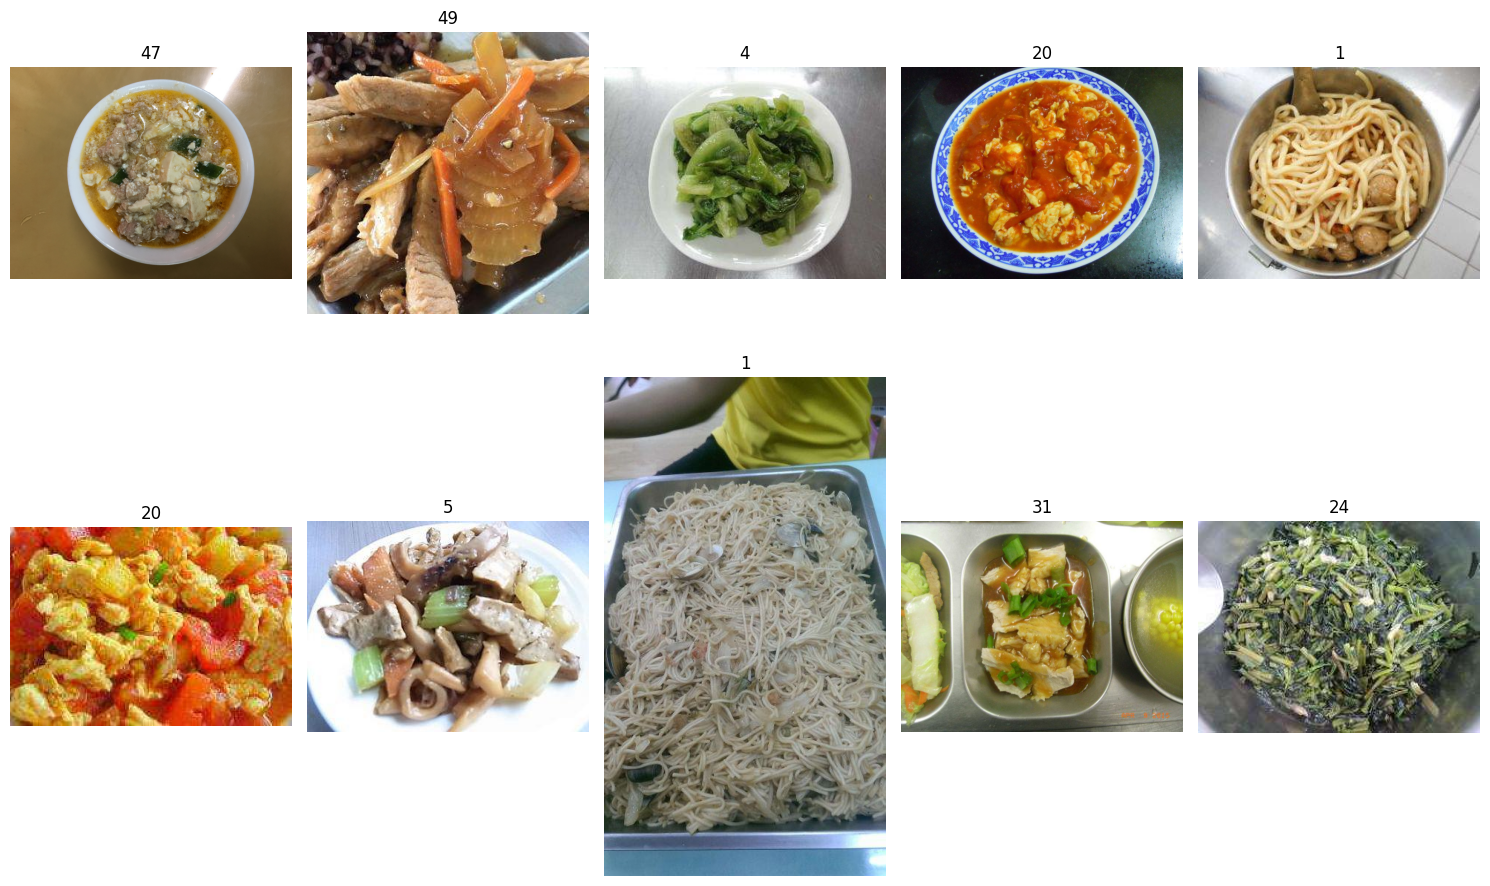

In [29]:
# 從資料夾讀取圖片並進行推論
image_paths = [os.path.join(DATA_DIR, fname) for fname in os.listdir(DATA_DIR) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
predictions = []

for image_path in image_paths[:10]:  # 處理前 10 張圖片
    image, prediction = predict_image(image_path, model, transform, CLASS_NAMES, DEVICE)
    predictions.append((image, prediction))

# 可視化結果
plt.figure(figsize=(15, 10))
# 設置字體路徑
# font_path = "C:/Windows/Fonts/simhei.ttf"  # 替換為你的字體文件路徑

# 設置全局字體
plt.rcParams['font.sans-serif'] = font_manager.FontProperties().get_name()
plt.rcParams['axes.unicode_minus'] = False  # 用來正常顯示負號
for i, (image, prediction) in enumerate(predictions):
    plt.subplot(2, 5, i + 1)  # 建立 2x5 的圖表佈局
    plt.imshow(image)
    plt.title(prediction)
    plt.axis("off")
plt.tight_layout()
plt.show()

[[474   0   0 ...   0   1   0]
 [  0 376   0 ...   0   0   0]
 [  0   0 526 ...   0   0   0]
 ...
 [  0   0   0 ... 209  48   0]
 [  0   0   0 ...  23 247   0]
 [  0   0   1 ...   0   0 232]]


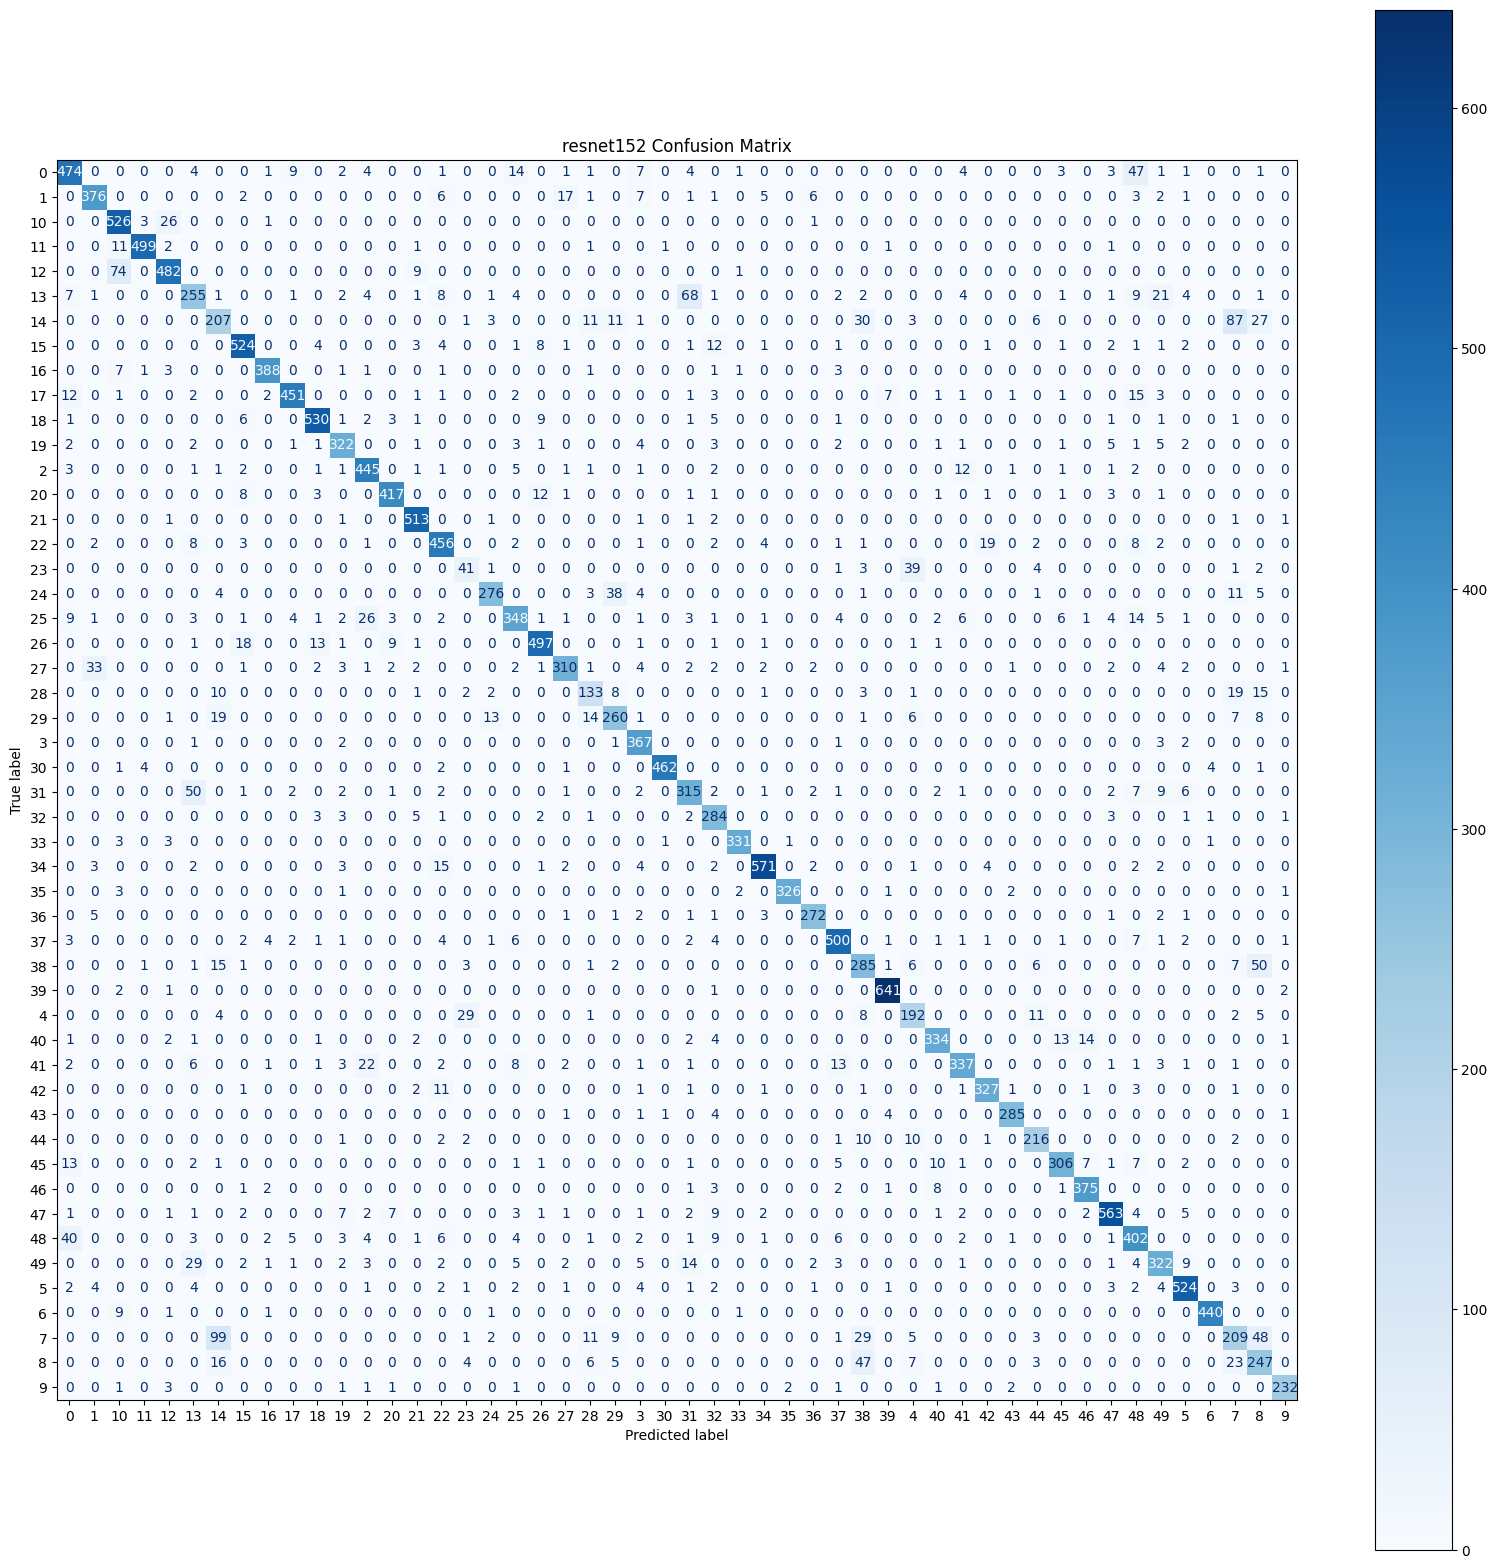

In [41]:
# 使用該函數在最後一輪訓練後繪製混淆矩陣
class_names = train_dataset.classes  # 替換為真實的類別名稱
plot_confusion_matrix(model, test_loader, DEVICE, class_names)